近似轮廓的边数: 4


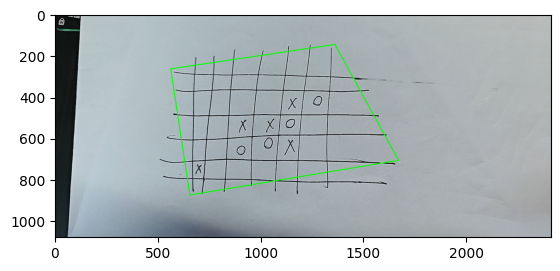

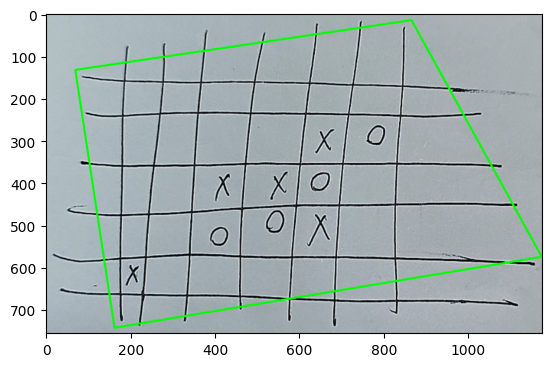

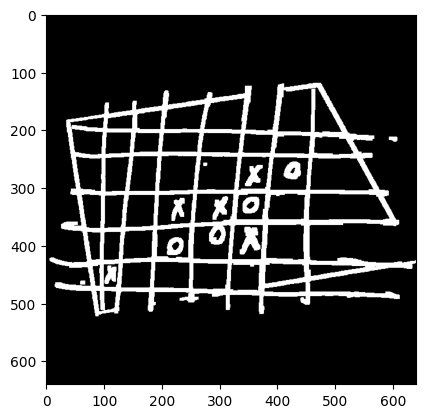

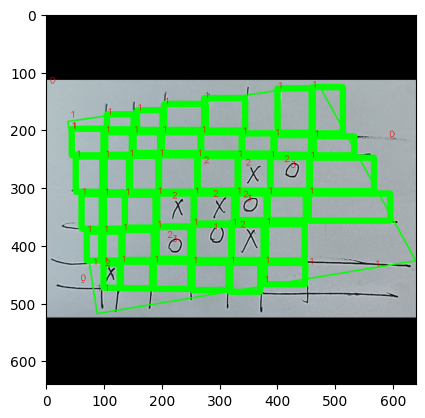

IndexError: index 4 is out of bounds for axis 0 with size 4

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取图像
image_path = 'hand4.jpg'  # 替换为你的图像路径


def resize_image_with_padding(image, target_size):
    """
    Resize the image to the target size while maintaining the aspect ratio
    and padding it to fit the target dimensions.

    :param image: Input image (numpy array)
    :param target_size: Target size (int) for both width and height
    :return: Resized and padded image (numpy array)
    """
    # 获取原始图像的尺寸
    original_height, original_width = image.shape[:2]

    # 计算缩放比例
    scale = target_size / max(original_width, original_height)

    # 计算新尺寸
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # 调整图像尺寸
    resized_img = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 创建一个新的空白图像
    new_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # 计算放置位置
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2

    # 将缩放后的图像放置到空白图像中
    new_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

    return new_img

def resize_and_pad_binary_image(binary_image, target_size):
    """
    Resize the binary image to the target size while maintaining the aspect ratio
    and padding it to fit the target dimensions.

    :param binary_image: Input binary image (numpy array)
    :param target_size: Target size (int) for both width and height
    :return: Resized and padded binary image (numpy array)
    """
    # 获取原始图像的尺寸
    original_height, original_width = binary_image.shape[:2]

    # 计算缩放比例
    scale = target_size / max(original_width, original_height)

    # 计算新尺寸
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # 调整图像尺寸
    resized_img = cv2.resize(binary_image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    # 创建一个新的空白图像（全黑），以目标大小填充
    new_img = np.zeros((target_size, target_size), dtype=np.uint8)

    # 计算放置位置
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2

    # 将缩放后的二值图像放置到空白图像中
    new_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

    return new_img

def find_chessboard(image_path):
    img = cv2.imread(image_path)

    # 2. 图像预处理
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)  # 二值化
    # 膨胀
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=8)
    # plt.imshow(binary, cmap='gray')
    # plt.title('Binary Image')
    # plt.axis('off')
    # plt.show()

    # 3. 检测轮廓
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 检测轮廓

    # 初始化最大面积和相应的轮廓
    max_area = 0
    board_contour = None

    # 遍历所有轮廓，找到最大面积的轮廓
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:  # 如果当前区域大于最大区域
            max_area = area
            board_contour = contour  # 更新最大区域对应的轮廓

    # 如果找到了棋盘轮廓
    if board_contour is not None:
        # cv2.drawContours(img, [board_contour], -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
        # 获取棋盘的边界框
        x, y, w, h = cv2.boundingRect(board_contour)
        chessboard = img[y:y+h, x:x+w]
        epsilon = 0.04 * cv2.arcLength(board_contour, True)  # 设置近似的精度，这里是以轮廓周长的4%作为阈值
        approx = cv2.approxPolyDP(board_contour, epsilon, True)  # 近似轮廓
        
        # 绘制近似轮廓（可选）
        cv2.drawContours(img, [approx], -1, (0, 255, 0), 3)
        num_sides = len(approx)
        print("近似轮廓的边数:", num_sides)
        
    plt.imshow(img)
    plt.show()
    
    gray = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 使用高斯模糊
    canny = cv2.Canny(blurred, 50, 150)
    #先稀释一下然后膨胀
    kernel = np.ones((5, 5), np.uint8)
    # eroded = cv2.erode(canny, kernel, iterations=1)
    dilated = cv2.dilate(canny, kernel, iterations=2)
    
    gray_chessboard = resize_and_pad_binary_image(dilated, 640)
    return chessboard,gray_chessboard

def get_grid_info(gray_chessboard):
    contours, hierarchy = cv2.findContours(gray_chessboard,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    point_array = []
    coordinates_dict = {}
    resize_chessboard = resize_image_with_padding(chessboard, 640)
    # 绘制小轮廓，大轮廓剔除
    for i, cnt in enumerate(contours):
        # 检查当前轮廓的层级，如果父轮廓的索引是 -1，说明它是第0层级
        level = 0
        parent_index = hierarchy[0][i][3]  # 父轮廓索引
        while parent_index != -1:
            level += 1
            parent_index = hierarchy[0][parent_index][3]  # 父轮廓索引
        if level == 1:  # 1rd dimension indicates parent index
            x, y, w, h = cv2.boundingRect(cnt)
            if w>200 or h>200 or w<25 or h<25:
                continue
            # 计算轮廓的边界框位置
            point_array.append((x,y))
            coordinates_dict[(x, y)] = (w, h)
            cv2.rectangle(resize_chessboard, (x, y), (x + w, y + h), (0, 255, 0), 10)
    return point_array,coordinates_dict,resize_chessboard

def arange_grid(point_array,threshold_y = 20,threshold_x = 20):
    # from scipy.spatial.distance import pdist, squareform
    points_with_sums = [(x, y, x + y) for (x, y) in point_array]
    min_point = min(points_with_sums, key=lambda p: p[2])  # p[2] 是 x + y 的值
    min_x, min_y = min_point[0], min_point[1]
    # chessboard_copy = resize_image_with_padding(chessboard, 640)
    points = point_array
    reference_y = min_y

    def is_floating_point1(points, reference_y, threshold):
        floating_points = []
        for point in points:
            if reference_y - threshold <= point[1] <= reference_y + threshold:
                floating_points.append(point)
            if floating_points:
                reference_y = floating_points[-1][1]
        return sorted(floating_points, key=lambda p: p[0])
    def is_floating_point2(points, reference_x, threshold):
        floating_points = []
        for point in points:
            if reference_x - threshold <= point[0] <= reference_x + threshold:
                floating_points.append(point)
            if floating_points:
                reference_x = floating_points[-1][0]
        return sorted(floating_points, key=lambda p: p[1])
        # 在图像中绘制这些点
    points = sorted(points, key=lambda p: p[0])
    floating_points_sorted = is_floating_point1(points, reference_y, threshold_y)
    lines = []
    points = sorted(points, key=lambda p: p[1])
    for floating_point in floating_points_sorted:
        lines.append(is_floating_point2(points, floating_point[0], threshold_x))

    return lines

def get_chessboard_states(lines,gray_chessboard,shrink_factor=7):
    h,w = len(lines[0]),len(lines)
    chessboard_states=np.zeros((h,w))
    white_ratio_board = np.zeros((h,w))
    # count = 0
    for i,line in enumerate(lines):
        for j,point in enumerate(line):
            x,y = point
            w,h = coordinates_dict[point]
            if w<42 or h<42:
                shrink_factor = 3
            else:
                shrink_factor = 7
            # region = dilated[y:y+h,x:x+w]
            # shrink_factor = 7  # 定义收窄的像素值
            x_shrinked =  x + shrink_factor  # 边界不超出原图像
            y_shrinked = y + shrink_factor
            w_shrinked = max(0, w - 2 * shrink_factor)  # 收窄宽度
            h_shrinked = max(0, h - 2 * shrink_factor)  # 收窄高度

            # 确保收窄后的边界不会超出图像范围
            region = gray_chessboard[y_shrinked:y_shrinked + h_shrinked, x_shrinked:x_shrinked + w_shrinked]
            # 腐蚀
            # kernel = np.ones((3, 3), np.uint8)
            # region = cv2.erode(region, kernel, iterations=1)
            total_pixels = region.size  # 总像素数
            white_pixels = np.sum(region == 255)  # 白色像素数

            # 计算白色像素占比
            white_ratio = white_pixels / total_pixels if total_pixels > 0 else 0
            white_ratio_board[j,i] = white_ratio
            if white_ratio > 0.1:
                #提取轮廓
                contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours) > 1:
                    logest_contour = max(contours, key=cv2.contourArea)
                    perimeter = cv2.arcLength(logest_contour, True)
                    area = cv2.contourArea(logest_contour)
                    if perimeter > 0 and area > 0 and perimeter / (2 * np.pi * np.sqrt(area / np.pi)) < 1.3:
                    # print(f"识别到圆形 ({j}, {i})")
                    # count += 1
                        chessboard_states[j,i]=1
                    else:
                        chessboard_states[j,i]=2
                    # print(f"区域 ({j}, {i}) 包含多个轮廓")
                    #用shrink_factor缩小轮廓
                    # notion = np.zeros_like(region)
                    # notion[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor] = region[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor]
                    # region = notion
                    # contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    # print(f"缩小后区域 ({j}, {i}) 包含 {len(contours)} 个轮廓")
                #判断是否为圆形
                if len(contours) == 1:
                    #计算轮廓的面积
                    area = cv2.contourArea(contours[0])
                    #计算周长
                    perimeter = cv2.arcLength(contours[0], True)
                
                    #判断是否为圆形
                    if perimeter > 0 and area > 0 and perimeter / (2 * np.pi * np.sqrt(area / np.pi)) < 1.5:
                        chessboard_states[j,i]=1
                    else:
                        chessboard_states[j,i]=2
    return chessboard_states,white_ratio_board

chessboard,gray_chessboard = find_chessboard(image_path)
plt.imshow(chessboard)
plt.show()
plt.imshow(gray_chessboard,cmap='gray')
plt.show()

point_array,coordinates_dict,resize_chessboard = get_grid_info(gray_chessboard)
contours, hierarchy = cv2.findContours(gray_chessboard,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
def show_hierarchy(contours,hierarchy):
    for i, cnt in enumerate(contours):
        # 绘制轮廓
        # 获取轮廓的边界框
        x, y, w, h = cv2.boundingRect(cnt)

        # 根据 hierachy 获取当前轮廓的层级
        level = 0
        parent_index = hierarchy[0][i][3]  # 父轮廓索引
        # cv2.putText(resize_chessboard, str(parent_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)

        # if parent_index==2:
        #     cv2.drawContours(resize_chessboard, contours, i, (255,), 1)  # 绘制当前轮廓，白色

        while parent_index != -1:  # -1 表示没有父轮廓
            level += 1
            parent_index = hierarchy[0][parent_index][3]  # 跳到父轮廓
        cv2.putText(resize_chessboard, str(level), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)
    # cv2.drawContours(resize_chessboard, contours, -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
show_hierarchy(contours,hierarchy)
plt.imshow(resize_chessboard)
plt.show()
lines = arange_grid(point_array)
# print(lines)
chessboard_states,white_ratio_board = get_chessboard_states(lines,gray_chessboard)
print(chessboard_states)
# print(white_ratio_board)
# 3. 显示结果
chessboard_copy = resize_image_with_padding(chessboard, 640)
def show_lines(lines,chessboard_copy):
    for line in lines:
        for point in line:
            cv2.circle(chessboard_copy, point, 5, (255, 0, 0), -1)  # 绘制蓝色圆点
            x,y = point
            w,h = coordinates_dict[point]
            # cv2.rectangle(chessboard_copy, (x, y), (x + w, y + h), (0, 255, 0), 10)  # 绘制矩形框
            plt.imshow(chessboard_copy)
            plt.show()
# show_lines(lines,chessboard_copy)

# plt.imshow(chessboard_copy)
# plt.show()
# #识别xx和圆形
# plt.imshow(gray_chessboard,cmap='gray')
# plt.show()
# chessboard_copy = resize_image_with_padding(chessboard, 640)
# print(len(lines),len(lines[0]))
# h,w = len(lines[0]),len(lines)
# chessboard_states=np.zeros((h,w))
# count = 0
def show_region(lines,gray_chessboard,shrink_factor=7):
    for i,line in enumerate(lines):
        for j,point in enumerate(line):
            x,y = point
            w,h = coordinates_dict[point]
            # region = dilated[y:y+h,x:x+w]
            if w<42 or h<42:
                shrink_factor = 3
            else:
                shrink_factor = 7  # 定义收窄的像素值
            x_shrinked =  x + shrink_factor  # 边界不超出原图像
            y_shrinked = y + shrink_factor
            w_shrinked = max(0, w - 2 * shrink_factor)  # 收窄宽度
            h_shrinked = max(0, h - 2 * shrink_factor)  # 收窄高度

            # 确保收窄后的边界不会超出图像范围
            region = gray_chessboard[y_shrinked:y_shrinked + h_shrinked, x_shrinked:x_shrinked + w_shrinked]
            # kernel = np.ones((3, 3), np.uint8)
            # #开运算
            # region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel)
            # region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel)
            # region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel)
            # region = cv2.erode(region, kernel, iterations=1)
            total_pixels = region.size  # 总像素数
            white_pixels = np.sum(region == 255)  # 白色像素数

            # 计算白色像素占比
            white_ratio = white_pixels / total_pixels if total_pixels > 0 else 0
            if white_ratio > 0.1:
                #提取轮廓
                contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                if len(contours) > 1:
                    print(f"区域 ({j}, {i}) 包含多个轮廓")
                    logest_contour = max(contours, key=cv2.contourArea)
                    perimeter = cv2.arcLength(logest_contour, True)
                    area = cv2.contourArea(logest_contour)
                    print(perimeter / (2 * np.pi * np.sqrt(area / np.pi)))
                    #用膨胀
                    # region = cv2.dilate(region, kernel, iterations=2)
                    # plt.imshow(region,cmap='gray')
                    # plt.show()
                    # contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    plt.imshow(region,cmap='gray')
                    plt.show()
                    contour_image = np.zeros_like(region)
                    cv2.drawContours(contour_image, logest_contour, -1, (255,), 2)  # 填充为白色
                    plt.imshow(contour_image, cmap='gray')
                    plt.title('Contours')
                    plt.show()
                    
                    # notion = np.zeros_like(region)
                    # notion[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor] = region[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor]
                    # region = notion
                    # contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    print(f"缩小后区域 ({j}, {i}) 包含 {len(contours)} 个轮廓")
                #判断是否为圆形
                if len(contours) == 1:
                    #计算轮廓的面积
                    area = cv2.contourArea(contours[0])
                    #计算周长
                    perimeter = cv2.arcLength(contours[0], True)
                    #画出轮廓
                    contour_image = np.zeros_like(region)
                    # 画出轮廓
                    cv2.drawContours(contour_image, contours, -1, (255,), 2)  # 填充为白色
                    # plt.imshow(contour_image, cmap='gray')
                    print(perimeter / (2 * np.pi * np.sqrt(area / np.pi)))
                    # plt.title('Contours')
                    # plt.show()
                    #判断是否为圆形
                    if perimeter > 0 and area > 0 and perimeter / (2 * np.pi * np.sqrt(area / np.pi)) < 1.3:
                        # print(f"识别到圆形 ({j}, {i})")
                        # count += 1
                        chessboard_states[j,i]=1
                    else:
                        chessboard_states[j,i]=2
                    # plt.imshow(region,cmap='gray')
                    # plt.show()
                # plt.imshow(region,cmap='gray')
                # plt.show()
                # count += 1
            if j==3:
                print(f"区域 ({j}, {i}) 的白色占比: {white_ratio:.2f}")
                print(w,h)
                plt.imshow(region,cmap='gray')
                plt.show()
# # print(f"共识别 {count} 个圆形")
# print(chessboard_states)




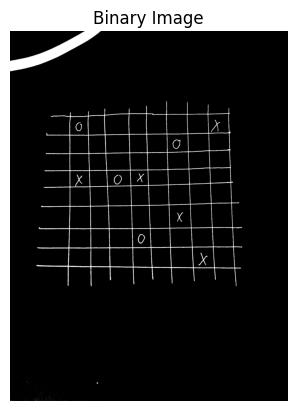

检测到棋盘，面积为3019942.5


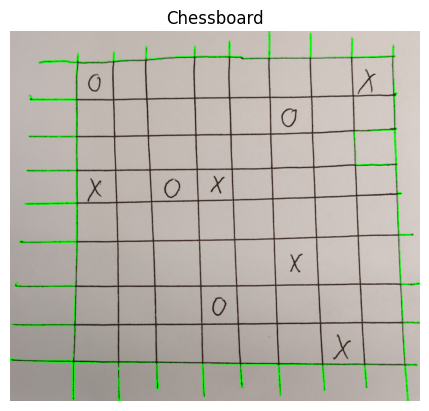

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # 1. 读取图像
# image_path = 'hand.jpg'  # 替换为你的图像路径
# img = cv2.imread(image_path)

# # 2. 图像预处理
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
#直方图均衡
# gray = cv2.equalizeHist(gray)
# _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)  # 二值化
# plt.imshow(binary, cmap='gray')
# plt.title('Binary Image')
# plt.axis('off')
# plt.show()

# # 3. 检测轮廓
# contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # 4. 绘制轮廓并识别棋盘
# board_contour = None
# for contour in contours:
#     area = cv2.contourArea(contour)
#     if area > 500:  # 大于一定的面积，可能为棋盘
#         print(f'检测到棋盘，面积为{area}')
#         board_contour = contour
#         break

# # 如果找到了棋盘轮廓
# if board_contour is not None:
#     cv2.drawContours(img, [board_contour], -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
#     # 获取棋盘的边界框
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     # plt.title('Detected Chessboard')
#     # plt.axis('off')
#     # plt.show()
    
#     x, y, w, h = cv2.boundingRect(board_contour)
#     chessboard = img[y:y+h, x:x+w]
#     plt.imshow(cv2.cvtColor(chessboard, cv2.COLOR_BGR2RGB))
#     plt.title('Chessboard')
#     plt.axis('off')
#     plt.show()




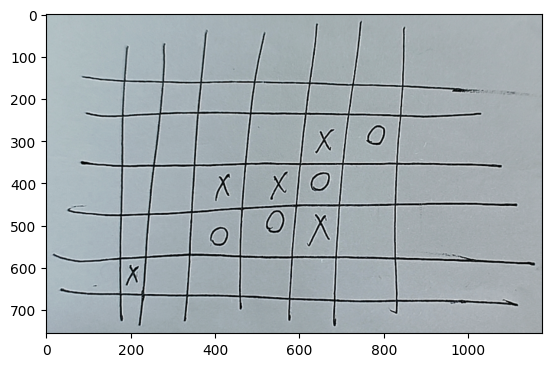

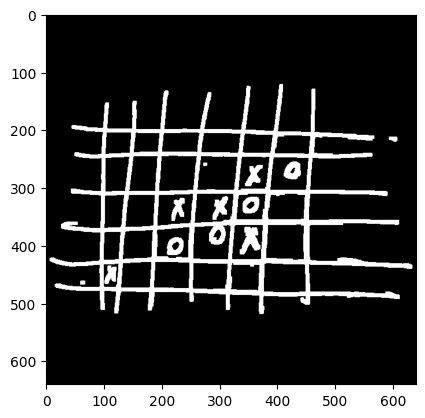

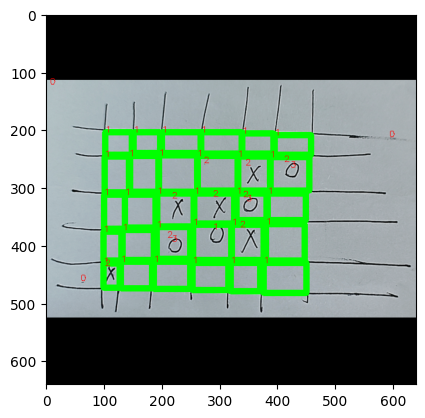

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 1.]
 [0. 0. 2. 2. 1. 0.]
 [0. 0. 1. 1. 2. 0.]
 [2. 0. 0. 0. 0. 0.]]


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取图像
image_path = 'hand4.jpg'  # 替换为你的图像路径


def resize_image_with_padding(image, target_size):
    """
    Resize the image to the target size while maintaining the aspect ratio
    and padding it to fit the target dimensions.

    :param image: Input image (numpy array)
    :param target_size: Target size (int) for both width and height
    :return: Resized and padded image (numpy array)
    """
    # 获取原始图像的尺寸
    original_height, original_width = image.shape[:2]

    # 计算缩放比例
    scale = target_size / max(original_width, original_height)

    # 计算新尺寸
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # 调整图像尺寸
    resized_img = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 创建一个新的空白图像
    new_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # 计算放置位置
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2

    # 将缩放后的图像放置到空白图像中
    new_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

    return new_img

def resize_and_pad_binary_image(binary_image, target_size):
    """
    Resize the binary image to the target size while maintaining the aspect ratio
    and padding it to fit the target dimensions.

    :param binary_image: Input binary image (numpy array)
    :param target_size: Target size (int) for both width and height
    :return: Resized and padded binary image (numpy array)
    """
    # 获取原始图像的尺寸
    original_height, original_width = binary_image.shape[:2]

    # 计算缩放比例
    scale = target_size / max(original_width, original_height)

    # 计算新尺寸
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # 调整图像尺寸
    resized_img = cv2.resize(binary_image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    # 创建一个新的空白图像（全黑），以目标大小填充
    new_img = np.zeros((target_size, target_size), dtype=np.uint8)

    # 计算放置位置
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2

    # 将缩放后的二值图像放置到空白图像中
    new_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

    return new_img

def find_chessboard(image_path):
    img = cv2.imread(image_path)

    # 2. 图像预处理
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)  # 二值化
    # 膨胀
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=8)
    # plt.imshow(binary, cmap='gray')
    # plt.title('Binary Image')
    # plt.axis('off')
    # plt.show()

    # 3. 检测轮廓
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 检测轮廓

    # 初始化最大面积和相应的轮廓
    max_area = 0
    board_contour = None

    # 遍历所有轮廓，找到最大面积的轮廓
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:  # 如果当前区域大于最大区域
            max_area = area
            board_contour = contour  # 更新最大区域对应的轮廓

    # 如果找到了棋盘轮廓
    if board_contour is not None:
        # cv2.drawContours(img, [board_contour], -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
        # 获取棋盘的边界框
        x, y, w, h = cv2.boundingRect(board_contour)
        chessboard = img[y:y+h, x:x+w]
    
    gray = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 使用高斯模糊
    canny = cv2.Canny(blurred, 50, 150)
    #先稀释一下然后膨胀
    kernel = np.ones((5, 5), np.uint8)
    # eroded = cv2.erode(canny, kernel, iterations=1)
    dilated = cv2.dilate(canny, kernel, iterations=2)
    
    gray_chessboard = resize_and_pad_binary_image(dilated, 640)
    return chessboard,gray_chessboard

def get_grid_info(gray_chessboard):
    contours, hierarchy = cv2.findContours(gray_chessboard,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    point_array = []
    coordinates_dict = {}
    resize_chessboard = resize_image_with_padding(chessboard, 640)
    # 绘制小轮廓，大轮廓剔除
    for i, cnt in enumerate(contours):
        # 检查当前轮廓的层级，如果父轮廓的索引是 -1，说明它是第0层级
        level = 0
        parent_index = hierarchy[0][i][3]  # 父轮廓索引
        while parent_index != -1:
            level += 1
            parent_index = hierarchy[0][parent_index][3]  # 父轮廓索引
        if level == 1:  # 1rd dimension indicates parent index
            x, y, w, h = cv2.boundingRect(cnt)
            if w>200 or h>200 or w<25 or h<25:
                continue
            # 计算轮廓的边界框位置
            point_array.append((x,y))
            coordinates_dict[(x, y)] = (w, h)
            cv2.rectangle(resize_chessboard, (x, y), (x + w, y + h), (0, 255, 0), 10)
    return point_array,coordinates_dict,resize_chessboard

def arange_grid(point_array,threshold_y = 20,threshold_x = 20):
    # from scipy.spatial.distance import pdist, squareform
    points_with_sums = [(x, y, x + y) for (x, y) in point_array]
    min_point = min(points_with_sums, key=lambda p: p[2])  # p[2] 是 x + y 的值
    min_x, min_y = min_point[0], min_point[1]
    # chessboard_copy = resize_image_with_padding(chessboard, 640)
    points = point_array
    reference_y = min_y

    def is_floating_point1(points, reference_y, threshold):
        floating_points = []
        for point in points:
            if reference_y - threshold <= point[1] <= reference_y + threshold:
                floating_points.append(point)
            if floating_points:
                reference_y = floating_points[-1][1]
        return sorted(floating_points, key=lambda p: p[0])
    def is_floating_point2(points, reference_x, threshold):
        floating_points = []
        for point in points:
            if reference_x - threshold <= point[0] <= reference_x + threshold:
                floating_points.append(point)
            if floating_points:
                reference_x = floating_points[-1][0]
        return sorted(floating_points, key=lambda p: p[1])
        # 在图像中绘制这些点
    points = sorted(points, key=lambda p: p[0])
    floating_points_sorted = is_floating_point1(points, reference_y, threshold_y)
    lines = []
    points = sorted(points, key=lambda p: p[1])
    for floating_point in floating_points_sorted:
        lines.append(is_floating_point2(points, floating_point[0], threshold_x))

    return lines

def get_chessboard_states(lines,gray_chessboard,shrink_factor=7):
    h,w = len(lines[0]),len(lines)
    chessboard_states=np.zeros((h,w))
    white_ratio_board = np.zeros((h,w))
    # count = 0
    for i,line in enumerate(lines):
        for j,point in enumerate(line):
            x,y = point
            w,h = coordinates_dict[point]
            if w<42 or h<42:
                shrink_factor = 3
            else:
                shrink_factor = 7
            # region = dilated[y:y+h,x:x+w]
            # shrink_factor = 7  # 定义收窄的像素值
            x_shrinked =  x + shrink_factor  # 边界不超出原图像
            y_shrinked = y + shrink_factor
            w_shrinked = max(0, w - 2 * shrink_factor)  # 收窄宽度
            h_shrinked = max(0, h - 2 * shrink_factor)  # 收窄高度

            # 确保收窄后的边界不会超出图像范围
            region = gray_chessboard[y_shrinked:y_shrinked + h_shrinked, x_shrinked:x_shrinked + w_shrinked]
            # 腐蚀
            # kernel = np.ones((3, 3), np.uint8)
            # region = cv2.erode(region, kernel, iterations=1)
            total_pixels = region.size  # 总像素数
            white_pixels = np.sum(region == 255)  # 白色像素数

            # 计算白色像素占比
            white_ratio = white_pixels / total_pixels if total_pixels > 0 else 0
            white_ratio_board[j,i] = white_ratio
            if white_ratio > 0.1:
                #提取轮廓
                contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours) > 1:
                    logest_contour = max(contours, key=cv2.contourArea)
                    perimeter = cv2.arcLength(logest_contour, True)
                    area = cv2.contourArea(logest_contour)
                    if perimeter > 0 and area > 0 and perimeter / (2 * np.pi * np.sqrt(area / np.pi)) < 1.3:
                    # print(f"识别到圆形 ({j}, {i})")
                    # count += 1
                        chessboard_states[j,i]=1
                    else:
                        chessboard_states[j,i]=2
                    # print(f"区域 ({j}, {i}) 包含多个轮廓")
                    #用shrink_factor缩小轮廓
                    # notion = np.zeros_like(region)
                    # notion[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor] = region[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor]
                    # region = notion
                    # contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    # print(f"缩小后区域 ({j}, {i}) 包含 {len(contours)} 个轮廓")
                #判断是否为圆形
                if len(contours) == 1:
                    #计算轮廓的面积
                    area = cv2.contourArea(contours[0])
                    #计算周长
                    perimeter = cv2.arcLength(contours[0], True)
                
                    #判断是否为圆形
                    if perimeter > 0 and area > 0 and perimeter / (2 * np.pi * np.sqrt(area / np.pi)) < 1.5:
                        chessboard_states[j,i]=1
                    else:
                        chessboard_states[j,i]=2
    return chessboard_states,white_ratio_board

chessboard,gray_chessboard = find_chessboard(image_path)
plt.imshow(chessboard)
plt.show()
plt.imshow(gray_chessboard,cmap='gray')
plt.show()

point_array,coordinates_dict,resize_chessboard = get_grid_info(gray_chessboard)
contours, hierarchy = cv2.findContours(gray_chessboard,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
def show_hierarchy(contours,hierarchy):
    for i, cnt in enumerate(contours):
        # 绘制轮廓
        # 获取轮廓的边界框
        x, y, w, h = cv2.boundingRect(cnt)

        # 根据 hierachy 获取当前轮廓的层级
        level = 0
        parent_index = hierarchy[0][i][3]  # 父轮廓索引
        # cv2.putText(resize_chessboard, str(parent_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)

        # if parent_index==2:
        #     cv2.drawContours(resize_chessboard, contours, i, (255,), 1)  # 绘制当前轮廓，白色

        while parent_index != -1:  # -1 表示没有父轮廓
            level += 1
            parent_index = hierarchy[0][parent_index][3]  # 跳到父轮廓
        cv2.putText(resize_chessboard, str(level), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)
    # cv2.drawContours(resize_chessboard, contours, -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
show_hierarchy(contours,hierarchy)
plt.imshow(resize_chessboard)
plt.show()
lines = arange_grid(point_array)
# print(lines)
chessboard_states,white_ratio_board = get_chessboard_states(lines,gray_chessboard)
print(chessboard_states)
# print(white_ratio_board)
# 3. 显示结果
chessboard_copy = resize_image_with_padding(chessboard, 640)
def show_lines(lines,chessboard_copy):
    for line in lines:
        for point in line:
            cv2.circle(chessboard_copy, point, 5, (255, 0, 0), -1)  # 绘制蓝色圆点
            x,y = point
            w,h = coordinates_dict[point]
            # cv2.rectangle(chessboard_copy, (x, y), (x + w, y + h), (0, 255, 0), 10)  # 绘制矩形框
            plt.imshow(chessboard_copy)
            plt.show()
# show_lines(lines,chessboard_copy)

# plt.imshow(chessboard_copy)
# plt.show()
# #识别xx和圆形
# plt.imshow(gray_chessboard,cmap='gray')
# plt.show()
# chessboard_copy = resize_image_with_padding(chessboard, 640)
# print(len(lines),len(lines[0]))
# h,w = len(lines[0]),len(lines)
# chessboard_states=np.zeros((h,w))
# count = 0
def show_region(lines,gray_chessboard,shrink_factor=7):
    for i,line in enumerate(lines):
        for j,point in enumerate(line):
            x,y = point
            w,h = coordinates_dict[point]
            # region = dilated[y:y+h,x:x+w]
            if w<42 or h<42:
                shrink_factor = 3
            else:
                shrink_factor = 7  # 定义收窄的像素值
            x_shrinked =  x + shrink_factor  # 边界不超出原图像
            y_shrinked = y + shrink_factor
            w_shrinked = max(0, w - 2 * shrink_factor)  # 收窄宽度
            h_shrinked = max(0, h - 2 * shrink_factor)  # 收窄高度

            # 确保收窄后的边界不会超出图像范围
            region = gray_chessboard[y_shrinked:y_shrinked + h_shrinked, x_shrinked:x_shrinked + w_shrinked]
            # kernel = np.ones((3, 3), np.uint8)
            # #开运算
            # region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel)
            # region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel)
            # region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel)
            # region = cv2.erode(region, kernel, iterations=1)
            total_pixels = region.size  # 总像素数
            white_pixels = np.sum(region == 255)  # 白色像素数

            # 计算白色像素占比
            white_ratio = white_pixels / total_pixels if total_pixels > 0 else 0
            if white_ratio > 0.1:
                #提取轮廓
                contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                if len(contours) > 1:
                    print(f"区域 ({j}, {i}) 包含多个轮廓")
                    logest_contour = max(contours, key=cv2.contourArea)
                    perimeter = cv2.arcLength(logest_contour, True)
                    area = cv2.contourArea(logest_contour)
                    print(perimeter / (2 * np.pi * np.sqrt(area / np.pi)))
                    #用膨胀
                    # region = cv2.dilate(region, kernel, iterations=2)
                    # plt.imshow(region,cmap='gray')
                    # plt.show()
                    # contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    plt.imshow(region,cmap='gray')
                    plt.show()
                    contour_image = np.zeros_like(region)
                    cv2.drawContours(contour_image, logest_contour, -1, (255,), 2)  # 填充为白色
                    plt.imshow(contour_image, cmap='gray')
                    plt.title('Contours')
                    plt.show()
                    
                    # notion = np.zeros_like(region)
                    # notion[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor] = region[shrink_factor:h_shrinked-shrink_factor,shrink_factor:w_shrinked-shrink_factor]
                    # region = notion
                    # contours, hierarchy = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    print(f"缩小后区域 ({j}, {i}) 包含 {len(contours)} 个轮廓")
                #判断是否为圆形
                if len(contours) == 1:
                    #计算轮廓的面积
                    area = cv2.contourArea(contours[0])
                    #计算周长
                    perimeter = cv2.arcLength(contours[0], True)
                    #画出轮廓
                    contour_image = np.zeros_like(region)
                    # 画出轮廓
                    cv2.drawContours(contour_image, contours, -1, (255,), 2)  # 填充为白色
                    # plt.imshow(contour_image, cmap='gray')
                    print(perimeter / (2 * np.pi * np.sqrt(area / np.pi)))
                    # plt.title('Contours')
                    # plt.show()
                    #判断是否为圆形
                    if perimeter > 0 and area > 0 and perimeter / (2 * np.pi * np.sqrt(area / np.pi)) < 1.3:
                        # print(f"识别到圆形 ({j}, {i})")
                        # count += 1
                        chessboard_states[j,i]=1
                    else:
                        chessboard_states[j,i]=2
                    # plt.imshow(region,cmap='gray')
                    # plt.show()
                # plt.imshow(region,cmap='gray')
                # plt.show()
                # count += 1
            if j==3:
                print(f"区域 ({j}, {i}) 的白色占比: {white_ratio:.2f}")
                print(w,h)
                plt.imshow(region,cmap='gray')
                plt.show()
# # print(f"共识别 {count} 个圆形")
# print(chessboard_states)


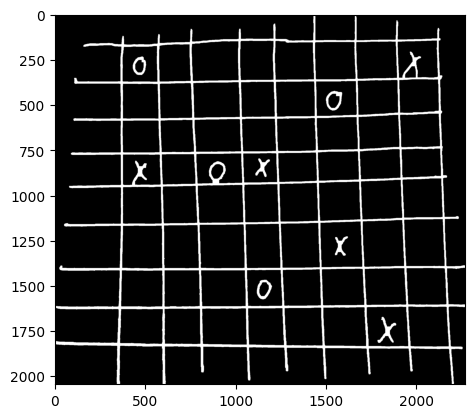

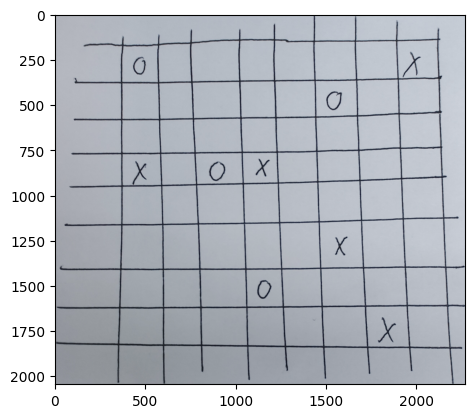

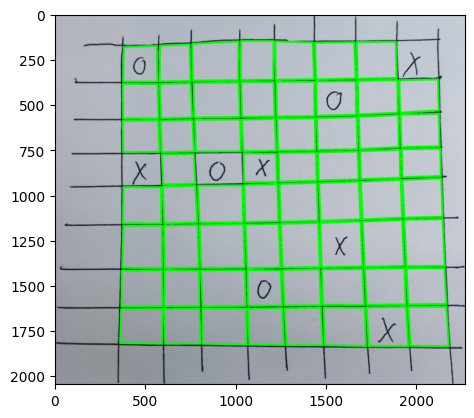

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取图像
image_path = 'hand.jpg'  # 替换为你的图像路径
img = cv2.imread(image_path)

# 2. 图像预处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)  # 二值化
# plt.imshow(binary, cmap='gray')
# plt.title('Binary Image')
# plt.axis('off')
# plt.show()

# 3. 检测轮廓
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. 绘制轮廓并识别棋盘
board_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 500:  # 大于一定的面积，可能为棋盘
        board_contour = contour
        break

# 如果找到了棋盘轮廓
if board_contour is not None:
    # cv2.drawContours(img, [board_contour], -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
    # 获取棋盘的边界框
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.title('Detected Chessboard')
    # plt.axis('off')
    # plt.show()
    x, y, w, h = cv2.boundingRect(board_contour)
    chessboard = img[y:y+h, x:x+w]
# chessboard = resize_image_with_padding(chessboard, 640)
gray = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 使用高斯模糊
# canny = cv2.Canny(blurred, 50, 150)

# # canny = cv2.Canny(gray, 50, 150)
# # plt.imshow(canny, cmap='gray')
# # plt.show()
# #先稀释一下然后膨胀
# kernel = np.ones((5, 5), np.uint8)
# # eroded = cv2.erode(canny, kernel, iterations=1)
# dilated = cv2.dilate(canny, kernel, iterations=2)
# plt.imshow(dilated, cmap='gray')
# plt.show()
# dilated = resize_and_pad_binary_image(dilated, 640)
# plt.imshow(dilated, cmap='gray')
# plt.show()
# kernel = np.ones((5, 5), np.uint8)
# dilated = cv2.dilate(canny, kernel, iterations=3)
# plt.imshow(dilated, cmap='gray')
# plt.show()
#直方图绘制
# hist = cv2.calcHist([canny], [0], None, [256], [0, 256])
# plt.clf()
# plt.plot(hist)
# plt.show()

# 5. 寻找网格
# 使用形态学操作来帮助找出网格
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(binary, kernel, iterations=5)
#稀释图像，使得轮廓更明显
dilated = cv2.erode(dilated, kernel, iterations=4)
plt.imshow(dilated, cmap='gray')
plt.show()
plt.imshow(chessboard)
plt.show()
# 寻找内部正方形



contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)


point_array = []

coordinates_dict = {}
resize_chessboard = resize_image_with_padding(chessboard, 640)
chessboard_copy = chessboard.copy()
# 绘制小轮廓，大轮廓剔除
# for i, cnt in enumerate(contours):
#     # 检查当前轮廓的层级，如果父轮廓的索引是 -1，说明它是第一层级
#     if hierarchy[0][i][3] == 0:  # 3rd dimension indicates parent index
#         # print(i)
#         # 绘制第一层级轮廓
#         x, y, w, h = cv2.boundingRect(cnt)
#         # cv2.drawContours(resize_chessboard, contours, i, (255,), 1)  # 绘制当前轮廓，白色
#         area = cv2.contourArea(cnt)
#         if w>200 or h>200 or w<10 or h<10:
#         # print(area)
#             continue
#         # 计算轮廓的边界框位置
#         point_array.append((x,y))
#         coordinates_dict[(x, y)] = (w, h)
    
#         cv2.rectangle(chessboard_copy, (x, y), (x + w, y + h), (0, 255, 0), 10)
#         # # 在轮廓中心位置标记层级信息
        # cv2.putText(resize_chessboard, 'Level 1', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)

# for i, cnt in enumerate(contours):
#     # 绘制轮廓
#     cv2.drawContours(resize_chessboard, contours, i, (255,), 1)  # 绘制当前轮廓，白色

#     # 获取轮廓的边界框
#     x, y, w, h = cv2.boundingRect(cnt)

#     # 根据 hierachy 获取当前轮廓的层级
#     level = 0
#     parent_index = hierarchy[0][i][3]  # 父轮廓索引
#     cv2.putText(resize_chessboard, str(parent_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)
#     while parent_index != -1:  # -1 表示没有父轮廓
#         level += 1
#         parent_index = hierarchy[0][parent_index][3]  # 跳到父轮廓

    # 在轮廓中心位置标记层级信息
    # cv2.putText(resize_chessboard, str(level), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,), 1)
    # cv2.putText(resize_chessboard, str(parent)


for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    #太大太小的都不考虑
    if area >100000 or w<10 or h<10:
        # print(area)
        continue
    # cv2.rectangle(chessboard_copy, (x, y), (x + w, y + h), (0, 255, 0), 10)
    # plt.imshow(chessboard_copy)
    # plt.show()
    # 对轮廓进行四边形格子近似
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    if len(approx) == 4:
        # print(approx)
        #画出approx外切矩形，并计算的左上角点和长宽
        x,y,w,h = cv2.boundingRect(approx)
        point_array.append((x,y))
        coordinates_dict[(x, y)] = (w, h)

        #将轮廓画出并展示
        # cv2.rectangle(chessboard_copy, (x, y), (x + w, y + h), (0, 255, 0), 10)
        cv2.drawContours(chessboard_copy, [approx], 0, (0, 255, 0), 10)
plt.imshow(chessboard_copy)
plt.show()
# print(point_array)
# 6. 计算棋盘格的坐标
# widths = []
# heights = []

# for (x, y), (w, h) in coordinates_dict.items():
#     widths.append(w)
#     heights.append(h)

# # 计算中位数
# median_width = np.median(widths)
# median_height = np.median(heights)

# # 输出结果
# print("宽度的中位数:", median_width)
# print("高度的中位数:", median_height)

    
       



In [ ]:
import numpy as np

# def insert_points(points, threshold):
#     global coordinates_dict, median_width, median_height
#     """
#     在 points 中相邻两个点的距离大于某个阈值时，在这两个点之间插入一个点
#     :param points: 点的列表，每个点是一个 (x, y) 元组
#     :param threshold: 距离阈值
#     :return: 插入新点后的点列表
#     """
#     new_points = []
    
#     for i in range(len(points) - 1):
#         point1 = points[i]
#         point2 = points[i + 1]
        
#         # 计算两点之间的距离
#         distance = point2[1]-point1[1]
        
#         # 如果距离大于阈值，插入一个新点
#         if distance > threshold:
#             # 计算新点的坐标
#             new_x = (point1[0] + point2[0]) / 2
#             new_y = (point1[1] + point2[1]) / 2
#             new_point = (int(new_x), int(new_y))
            
#             # 插入新点
#             new_points.append(point1)
#             new_points.append(new_point)
#             coordinates_dict[new_point] = (int(median_width), int(median_height))
#         else:
#             new_points.append(point1)
    
#     # 添加最后一个点
#     new_points.append(points[-1])
    
#     return new_points

# 示例点列表
# points = [(100, 150), (200, 155), (400, 140), (500, 170), (700, 160)]
# threshold = 150  # 设置距离阈值

# # 插入新点
# new_points = insert_points(points, threshold)

# # 输出结果
# print("插入新点后的点列表:", new_points)


In [148]:
# from scipy.spatial.distance import pdist, squareform
# points_with_sums = [(x, y, x + y) for (x, y) in point_array]
# min_point = min(points_with_sums, key=lambda p: p[2])  # p[2] 是 x + y 的值
# min_x, min_y = min_point[0], min_point[1]
# distance_thred = int(46*1.8)
# print("最小 x + y 点:", (min_x, min_y))
chessboard_copy = resize_image_with_padding(chessboard, 640)
# cv2.circle(chessboard_copy, (min_x, min_y), 10, (0, 0, 255), 3)  # 半径为 5，颜色为红色
# plt.imshow(chessboard_copy)
# plt.show()
# points = point_array
# reference_y = min_y
# threshold = 20
# floating_points = []
# def is_floating_point1(points, reference_y, threshold):
#     for point in points:
#         if reference_y - threshold <= point[1] <= reference_y + threshold:
#             floating_points.append(point)
#     return sorted(floating_points, key=lambda p: p[0])
# def is_floating_point2(points, reference_y, threshold):
#     floating_points = []
#     for point in points:
#         if reference_y - threshold <= point[0] <= reference_y + threshold:
#             floating_points.append(point)
#     return sorted(floating_points, key=lambda p: p[1])
#     # 在图像中绘制这些点
# floating_points_sorted = is_floating_point1(points, reference_y, threshold)
# # for point in floating_points_sorted:
# #     cv2.circle(chessboard_copy, point, 5, (0, 255, 0), -1)  # 绘制绿色圆点
# #     plt.imshow(chessboard_copy)
# #     plt.show()

# lines = []
# # lines.append(floating_points_sorted)
# for floating_point in floating_points_sorted:
#     # original = is_floating_point2(points, floating_point[0], threshold)
#     # after = insert_points(original, distance_thred)
#     # print(original)
#     # print(after)
#     # print(len(after), len(original))
#     lines.append(is_floating_point2(points, floating_point[0], threshold))
# print(len(lines))



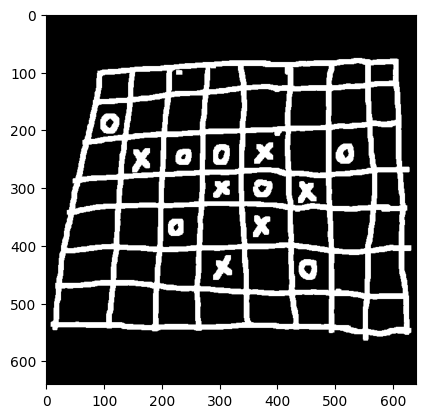

8 7
区域 (0, 0) 的白色占比: 0.00


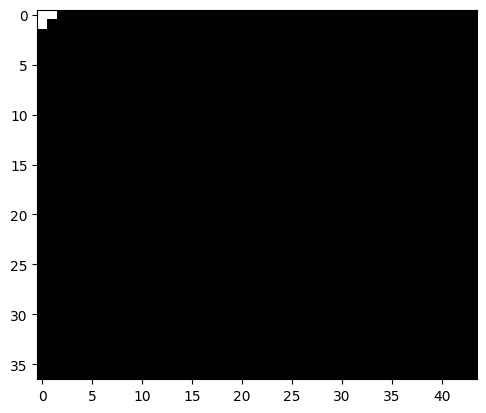

3
2
2
2
区域 (1, 0) 的白色占比: 0.02


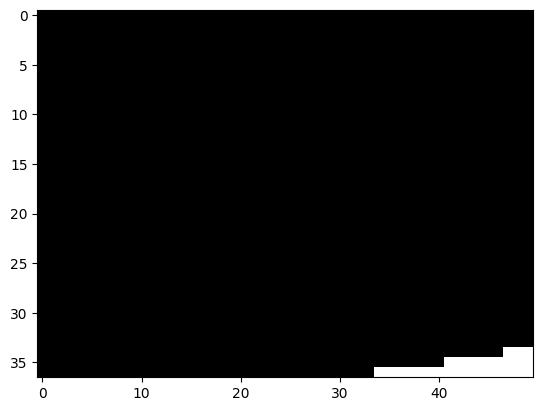

2
2
区域 (2, 0) 的白色占比: 0.05


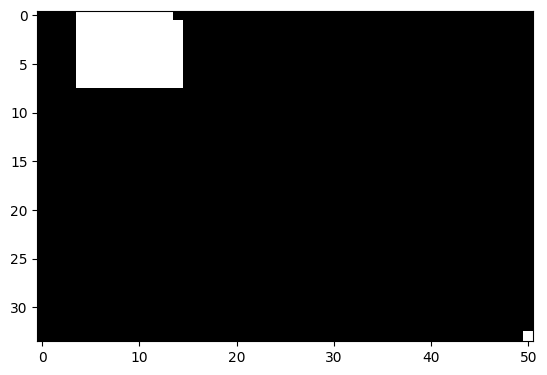

1
1.0711367661846292


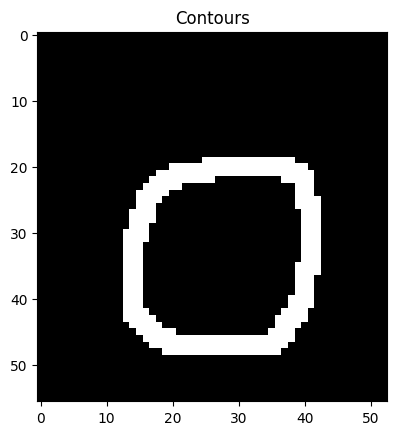

识别到圆形 (205, 208)


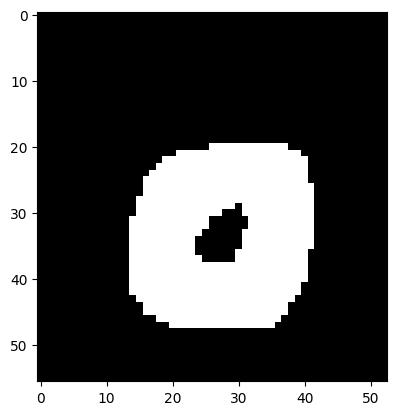

1
1.0744437388333776


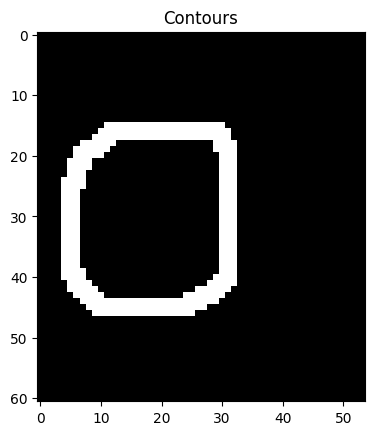

识别到圆形 (201, 333)


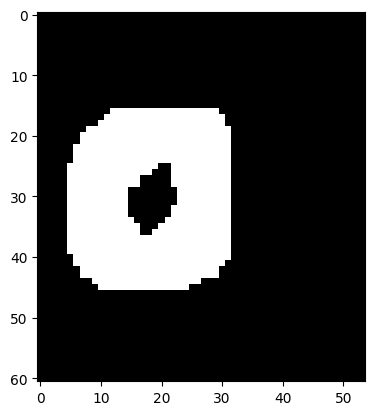

区域 (3, 0) 的白色占比: 0.01


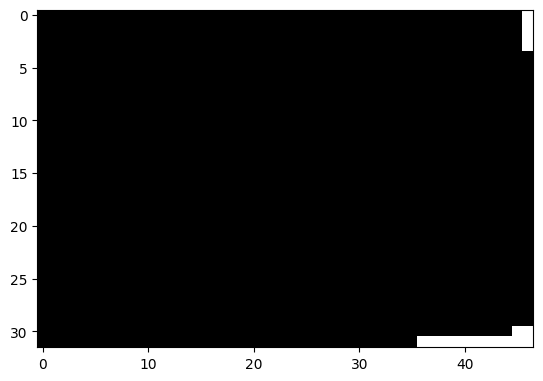

1
1.0867763861810928


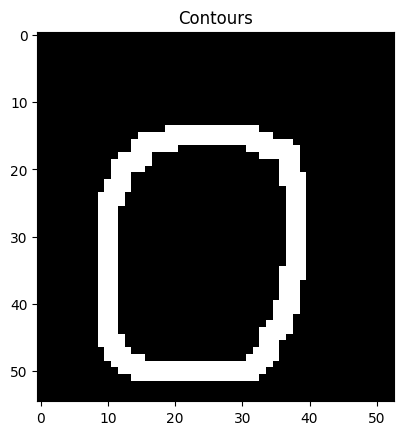

识别到圆形 (274, 205)


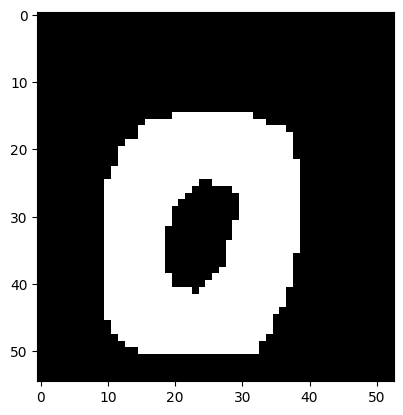

1
1.5012935293918668


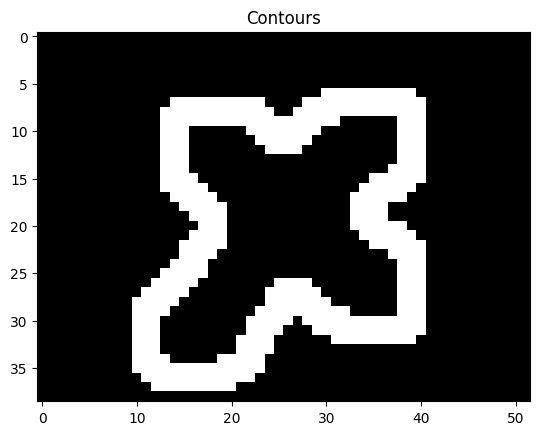

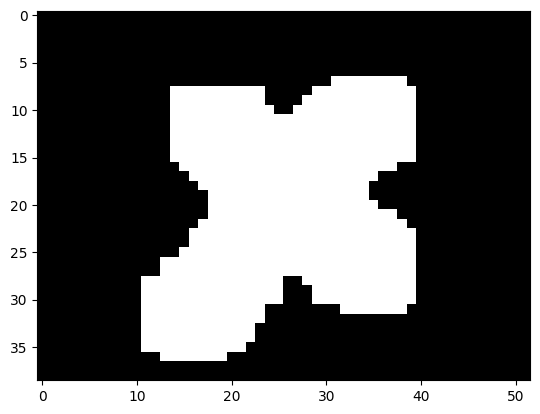

2
区域 (4, 0) 的白色占比: 0.01


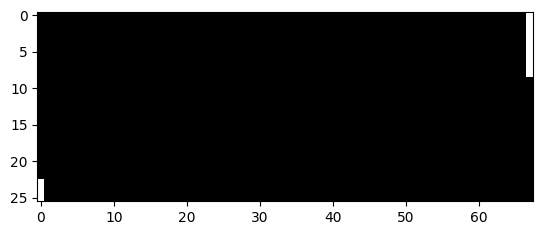

3
3
3
区域 (5, 0) 的白色占比: 0.00


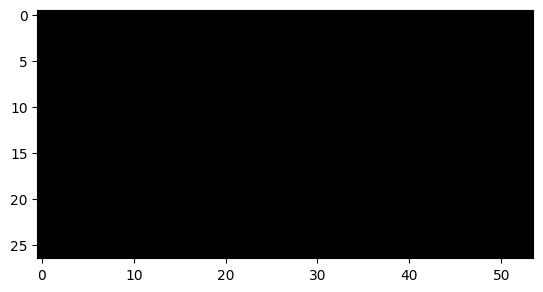

1
1.5838260073034585


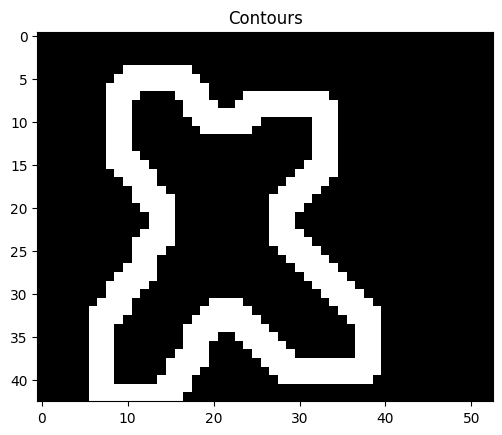

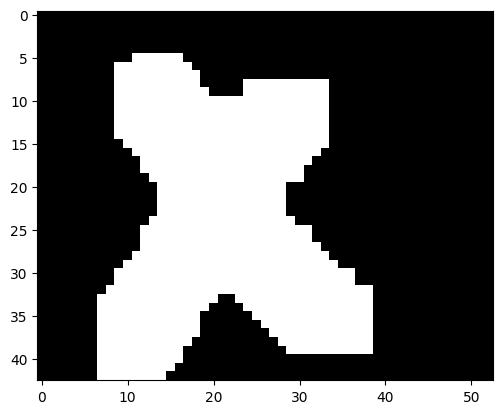

2
区域 (6, 0) 的白色占比: 0.01


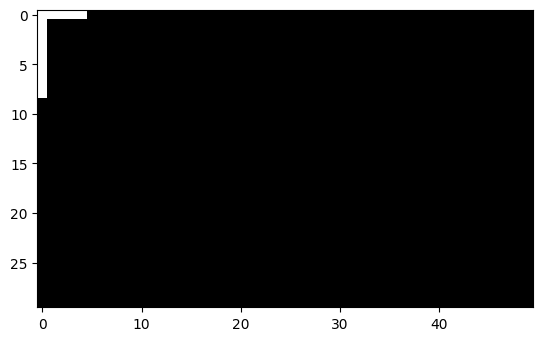

3
区域 (7, 0) 的白色占比: 0.00


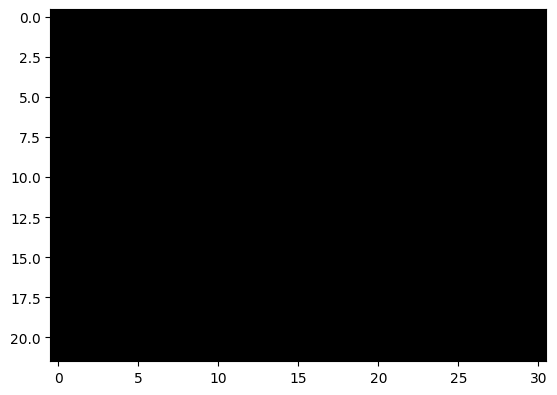

2
共识别 3 个圆形
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 2. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
 # (center_x, center_y), (width, height), angle = rect

        # # 宽度和高度可能需要调整，保证 width 是大值而 height 是小值
        # # if width < height:
        # #     width, height = height, width  # 确保 width 是更大的那个

        # # 计算左上角的坐标
        # left_top_x = center_x - width / 2
        # left_top_y = center_y - height / 2

        # # 返回的形式为 (x, y, width, height)
        # xywh = (left_top_x, left_top_y, width, height)

        # print("内切矩形的形式为 (x, y, w, h):", xywh)


        #画出左上角点，还有画出box，画粗一点
        # cv2.circle(chessboard, (x, y), 10, (0, 0, 255), -1)
        # cv2.rectangle(chessboard, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # cv2.circle(chessboard, (int(left_top_x), int(left_top_y)), 10, (0, 0, 255), -1)
        # cv2.rectangle(chessboard, (int(left_top_x), int(left_top_y)), (int(left_top_x + width), int(left_top_y + height)), (0, 255, 0), 2)
        
        #480*480的像素展示在屏幕中央
        # cv2.namedWindow("chessboard", cv2.WINDOW_NORMAL)
        # cv2.moveWindow("chessboard", 100, 100)
        # cv2.imshow("chessboard", cv2.resize(chessboard, (480, 480)))
        # # cv2.imshow("chessboard", chessboard)
        # cv2.waitKey(0)
        # cv2.drawContours(chessboard, [approx], 0, (0, 0, 255), 2)
        #获取approx中左上角的点
        #把这个approx做一个内切矩形
        # rect = cv2.minAreaRect(cnt)
        # box = cv2.boxPoints(rect)
        # box = np.int0(box)
        # cv2.drawContours(chessboard, [box], 0, (0, 255, 0), 2)
        # cv2.rectangle(chessboard, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # cv2.putText(chessboard, str(area), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        # plt.imshow(chessboard)
        # plt.show()


In [ ]:
# 导入相关库
import cv2
import numpy as np

# 读取图像
img = cv2.imread('board.png')
# cv2.imshow('img', img)

# 转换为灰度图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# print('gray:', gray.shape)
# cv2.imshow('gray', gray)

# 高斯模糊
blur = cv2.GaussianBlur(gray, (5, 5), 0)
# cv2.imshow('blur', blur)

# 边缘检测
edges = cv2.Canny(blur, 50, 150)
# cv2.imshow('edges', edges)

# 轮廓提取
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大的轮廓，即棋盘的轮廓
max_area = 0
max_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        max_contour = contour

# 找到最小外接矩形，即棋盘的四个角点
rect = cv2.minAreaRect(max_contour)
box = cv2.boxPoints(rect)
box = np.intp(box)

# 绘制轮廓和角点
cv2.drawContours(img, [box], 0, (0, 0, 255), 3)
for point in box:
    cv2.circle(img, tuple(point), 5, (0, 255, 0), -1)

width = int(rect[1][0])
height = int(rect[1][1])

warped = gray

# 圆检测，找到棋盘上的圆形，即棋子
circles = cv2.HoughCircles(warped, method=cv2.HOUGH_GRADIENT,
                           dp=1, minDist=25, param1=100, param2=19,
                           minRadius=10, maxRadius=20)
print('circles: ', circles)
circles = np.uint16(np.around(circles))

# 计算每个圆形所在的格子位置
grid_size = width // 18 # 棋盘有19x19个格子
centers = [] # 存储圆心坐标和格子位置
for i in circles[0,:]:
    cx = i[0] # 圆心x坐标
    cy = i[1] # 圆心y坐标
    r = i[2] # 圆半径
    # 计算格子行号和列号，从0开始
    row = round(cy / grid_size) - 4
    col = round(cx / grid_size) - 4
    # 绘制圆形和圆心
    cv2.circle(img,(cx,cy),r,(0,255,0),2)
    cv2.circle(img,(cx,cy),2,(0,0,255),2)
    # 添加到列表中
    centers.append((cx,cy,row,col))

# 颜色空间转换，将图像转换为HSV空间
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 阈值分割，根据黑子和白子的颜色范围分别设置阈值，得到两个二值图像
lower_black = np.array([0, 0 ,10])
upper_black = np.array([180 ,255 ,90])
mask_black = cv2.inRange(hsv, lower_black, upper_black)
lower_white = np.array([0, 0 ,100])
upper_white = np.array([180 ,30 ,255])
mask_white = cv2.inRange(hsv, lower_white, upper_white)

# 与运算，将二值图像和原图像相与，得到黑子和白子的图像
res_black = cv2.bitwise_and(img, img, mask=mask_black)
res_white = cv2.bitwise_and(img, img, mask=mask_white)

res_black = cv2.cvtColor(res_black, cv2.COLOR_BGR2GRAY)
res_white = cv2.cvtColor(res_white, cv2.COLOR_BGR2GRAY)

# cv2.imshow('res_black', res_black)
# cv2.imshow('res_white', res_white)

# 统计每个圆形区域内的非零像素个数，判断是否有棋子，以及棋子的颜色
stones = [] # 存储棋子的颜色和位置
for center in centers:
    cx, cy, row, col = center
    # 在黑子图像上取一个圆形区域
    black_roi = res_black[cy-r:cy+r, cx-r:cx+r]
    # 计算非零像素个数
    nz_count_black = cv2.countNonZero(black_roi)
    # 如果大于阈值，则判断为黑子
    if nz_count_black > 50:
        color = 'black'
        stones.append((color, row, col))

        cv2.putText(img, '(' + str(row+1) + ',' + str(col+1) + ')', (cx,cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

        continue
    # 在白子图像上取一个圆形区域
    white_roi = res_white[cy-r:cy+r, cx-r:cx+r]
    # 计算非零像素个数
    nz_count_white = cv2.countNonZero(white_roi)
    # 如果大于阈值，则判断为白子
    if nz_count_white > 50:
        color = 'white'
        stones.append((color, row, col))

        cv2.putText(img, '(' + str(row+1) + ',' + str(col+1) + ')', (cx,cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

        continue

print('num: ', len(stones))

# 输出棋子的颜色和位置信息
board = []
for i in range(19):
    b = []
    for j in range(19):
        b.append(0)
    board.append(b)

cnt = 0
for stone in stones:
    color, row, col = stone
    print(f'There is a {color} stone at row {row+1} and column {col+1}.')
    board[row][col] = 1 if color == 'white' else 2

print(board)


def check_win(board, x, y):
    def check_dir(dx, dy):
        cnt = 1
        tx, ty = x + dx, y + dy
        while tx >= 0 and tx <= 18 and ty >= 0 and ty <= 18 and board[tx][ty] == board[x][y]:
            cnt += 1
            tx += dx
            ty += dy
        return cnt

    for dx, dy in [(0, 1), (1, 0), (1, 1), (1, -1)]:
        if check_dir(dx, dy) + check_dir(-dx, -dy) - 1 >= 5:
            return True
    return False

flag = False
for stone in stones:
    color, row, col = stone
    if check_win(board, row, col):
        print(f"{color} stone Win!!! palce({row+1}, {col+1})")
        flag = True
        break

if not flag:
    print("No Win")

# 如果需要扩展功能，可以在这里添加检测五子连排的代码

# 显示图像
cv2.imshow('img', img)
# cv2.imshow('warped', warped)
cv2.waitKey(0)
cv2.destroyAllWindows()


# plt.imshow(gray_chessboard,cmap='gray')
# plt.show()
# 4. 绘制轮廓并识别棋盘
# board_contour = None
# for contour in contours:
#     area = cv2.contourArea(contour)
#     if area > 500:  # 大于一定的面积，可能为棋盘
#         board_contour = contour
#         break

# # 如果找到了棋盘轮廓
# if board_contour is not None:
#     # cv2.drawContours(img, [board_contour], -1, (0, 255, 0), 3)  # 绘制棋盘轮廓
#     # 获取棋盘的边界框
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     # plt.title('Detected Chessboard')
#     # plt.axis('off')
#     # plt.show()
#     x, y, w, h = cv2.boundingRect(board_contour)
#     chessboard = img[y:y+h, x:x+w]
# gray = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
# #直方图
# hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
# hist = hist / hist.sum()  
# plt.clf()
# plt.plot(hist)
# plt.title('Normalized Gray Level Histogram')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Normalized Frequency')
# plt.xlim([0, 256])  # 设置X轴范围
# plt.show()
# _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
# plt.imshow(binary, cmap='gray')
# plt.show()
#获取canny边缘
# edges = cv2.Canny(gray, 50, 150)
# plt.imshow(edges, cmap='gray')
# plt.show()
# #直线提取
# lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=200, minLineLength=50, maxLineGap=40)

# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]  # 获取线段的起始和结束坐标
#         cv2.line(chessboard, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 绘制线段
# plt.imshow(cv2.cvtColor(chessboard, cv2.COLOR_BGR2RGB))
# plt.show()


circles:  [[[ 77.5 357.5  13.6]
  [212.5 438.5  13.8]
  [104.5 113.5  13.6]
  [375.5 357.5  13.8]
  [239.5 357.5  13.6]
  [456.5  32.5  13.2]
  [321.5  86.5  13.6]
  [ 77.5 249.5  13.6]
  [348.5 384.5  13.8]
  [266.5 438.5  13.6]
  [212.5  86.5  13.6]
  [104.5 221.5  13.6]
  [348.5 221.5  13.6]
  [131.5  86.5  13.4]
  [240.5 249.5  13.8]
  [294.5 440.5  14.9]
  [348.5  59.5  14.1]
  [131.5 276.5  13.8]
  [186.5 275.5  13.8]
  [321.5 249.5  13.8]
  [267.5 167.5  13.6]
  [483.5 222.5  13.4]
  [157.5 331.5  13.4]
  [130.5 248.5  12.7]
  [159.5 412.5  14.7]
  [239.5 330.5  13.8]
  [213.5 276.5  13.8]
  [321.5 195.5  13.8]
  [159.5 302.5  13.8]
  [186.5 302.5  13.8]
  [294.5 276.5  13.8]
  [212.5 411.5  13.8]
  [158.5 248.5  13.6]
  [213.5 113.5  13.8]
  [401.5 438.5  13. ]
  [188.5 383.5  16.1]
  [266.5 359.5  14.9]
  [374.5 383.5  13.8]
  [429.5 383.5  13.6]
  [483.5 248.5  13.6]
  [131.5 143.5  15.5]
  [105.5 276.5  15. ]
  [295.5 303.5  14.9]
  [268.5 224.5  13.8]
  [429.5 411.5  13.6]


In [ ]:
# 使用示例
# image_path = 'binary_image_path.jpg'  # 替换为你的二值图像路径
# binary_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# # 确保输入为二值图像，可以按需进行阈值处理
# _, binary_img = cv2.threshold(binary_img, 128, 255, cv2.THRESH_BINARY)

# # 设置目标尺寸
# target_size = 640
# resized_and_padded_binary_img = resize_and_pad_binary_image(binary_img, target_size)

# # 显示结果
# cv2.imshow('Original Binary Image', binary_img)
# cv2.imshow('Resized and Padded Binary Image', resized_and_padded_binary_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# 使用示例
# image_path = 'hand.jpg'  # 替换为你的图像路径
# img = cv2.imread(image_path)
# target_size = 640
# resized_and_padded_img = resize_image_with_padding(img, target_size)

# # 显示结果
# cv2.imshow('Resized Image', resized_and_padded_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [3]:
# #实现一个滑杆控制HSV阈值
# import cv2
# import numpy as np

# def nothing(x):
#     pass

# # Create a black image, a window
# img =  cv2.imread('board.png')
# cv2.namedWindow('image')

# # create trackbars for color change
# cv2.createTrackbar('H_min','image',0,179,nothing)
# cv2.createTrackbar('S_min','image',0,255,nothing)
# cv2.createTrackbar('V_min','image',0,255,nothing)
# cv2.createTrackbar('H_max','image',0,179,nothing)
# cv2.createTrackbar('S_max','image',0,255,nothing)
# cv2.createTrackbar('V_max','image',0,255,nothing)

# while(1):
    

#         # get current positions of four trackbars
#     h_min = cv2.getTrackbarPos('H_min','image')
#     s_min = cv2.getTrackbarPos('S_min','image')
#     v_min = cv2.getTrackbarPos('V_min','image')
#     h_max = cv2.getTrackbarPos('H_max','image')
#     s_max = cv2.getTrackbarPos('S_max','image')
#     v_max = cv2.getTrackbarPos('V_max','image')

#     # define range of color in HSV
#     lower = np.array([h_min,s_min,v_min])
#     upper = np.array([h_max,s_max,v_max])

#     # create mask
#     mask = cv2.inRange(img,lower,upper)

#     # apply mask and display image
#     res = cv2.bitwise_and(img,img,mask=mask)
#     cv2.imshow('mask',mask)
#     cv2.imshow('res',res)
#     cv2.imshow('image',img)
#     k = cv2.waitKey(1) & 0xFF
#     if k == 27:
#         break

# cv2.destroyAllWindows()

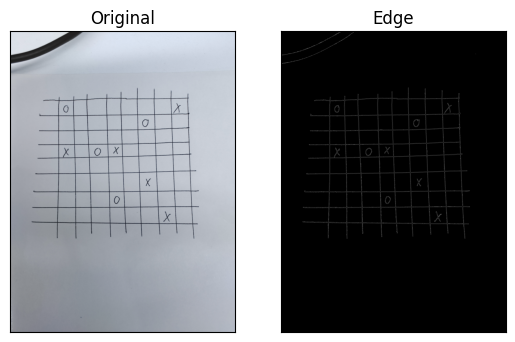

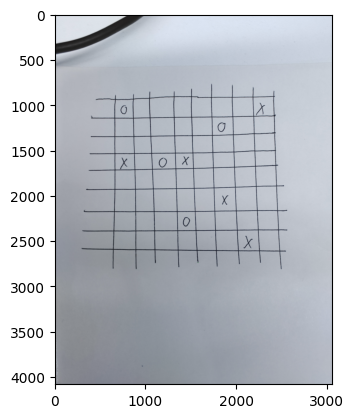

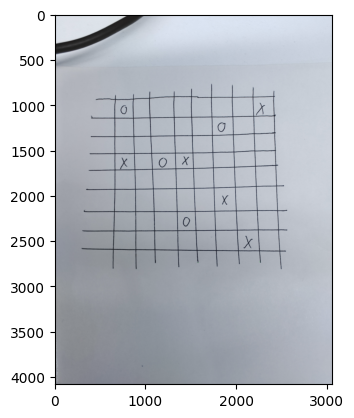

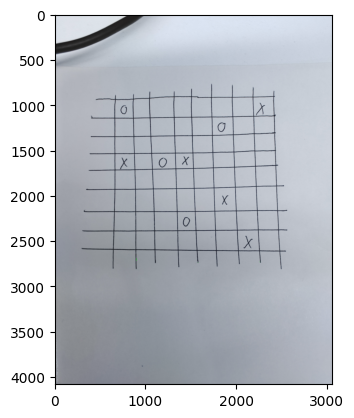

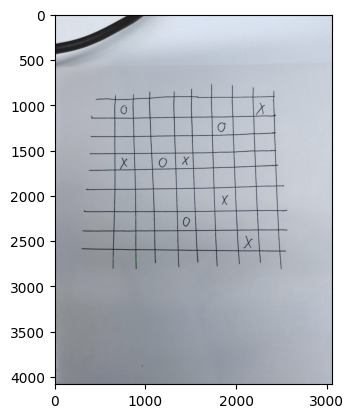

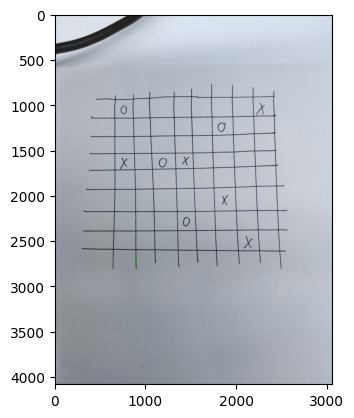

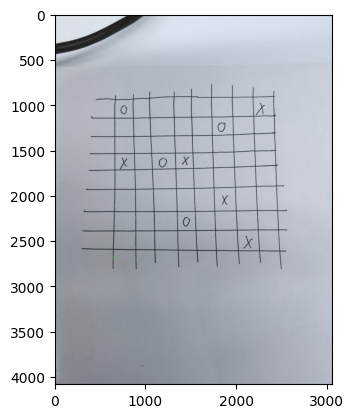

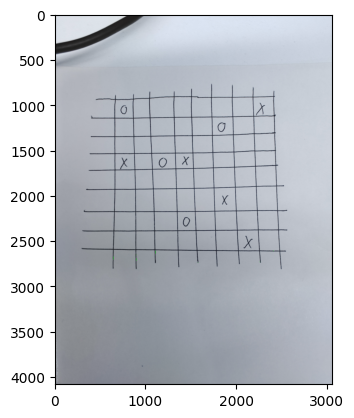

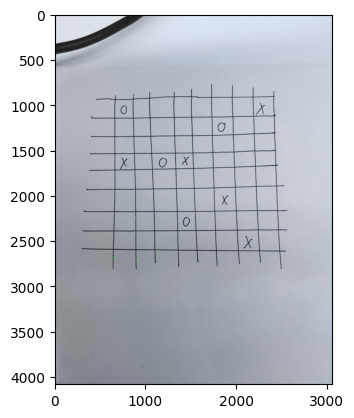

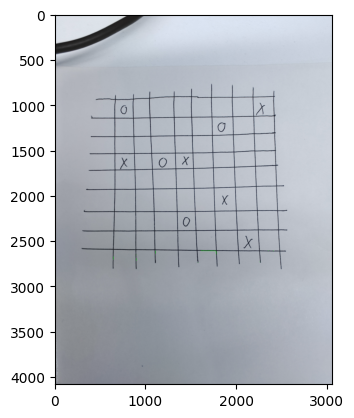

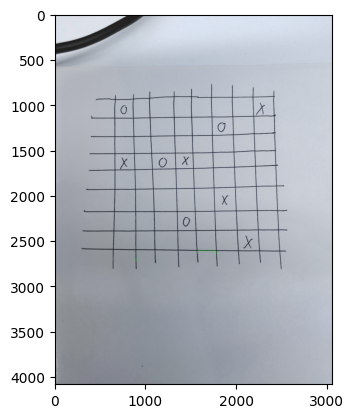

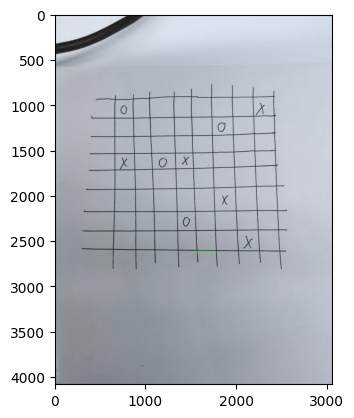

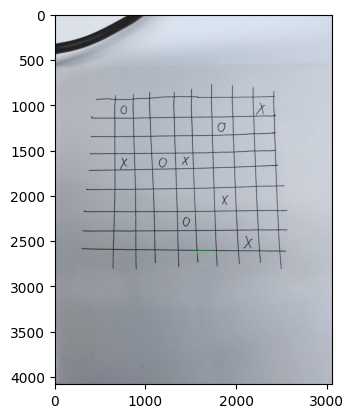

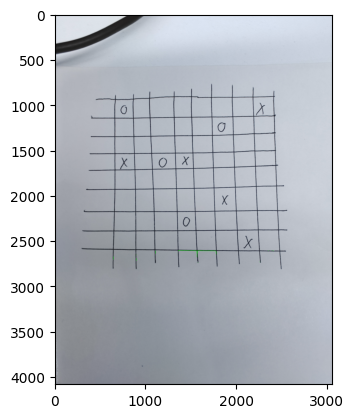

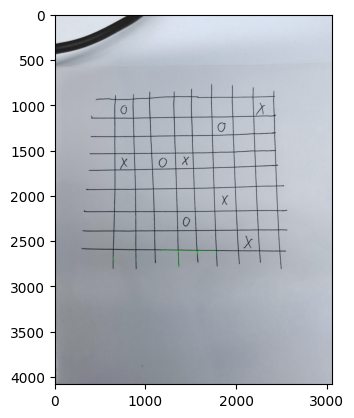

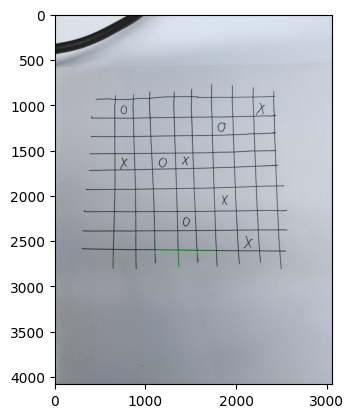

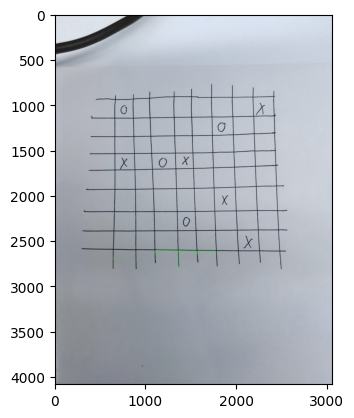

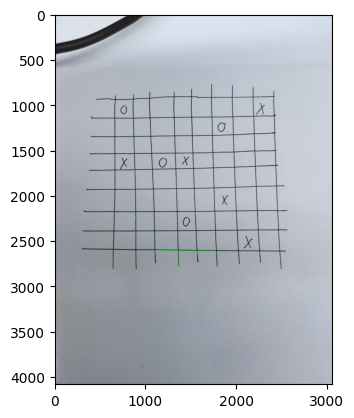

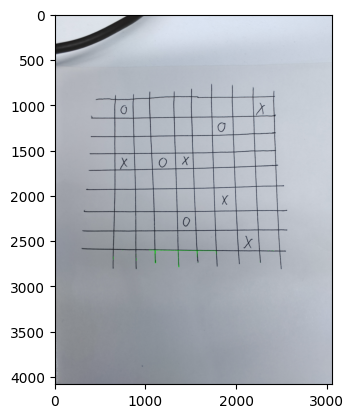

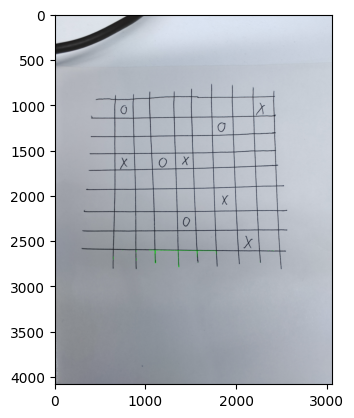

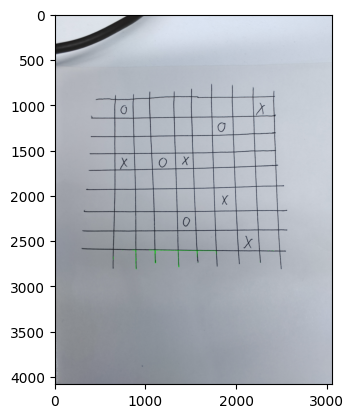

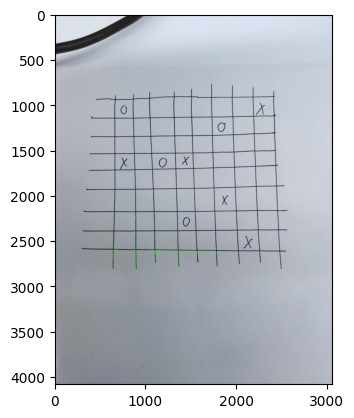

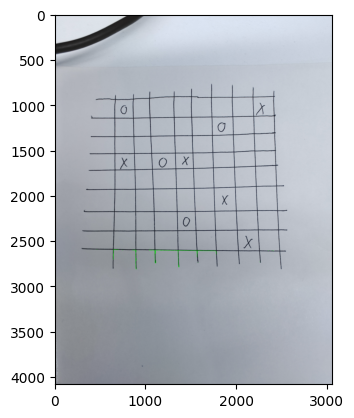

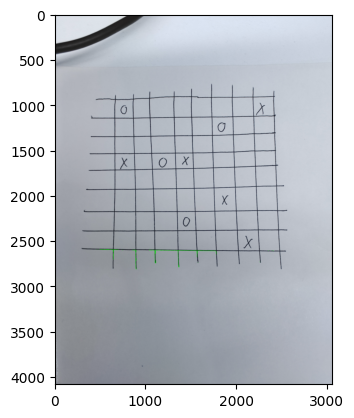

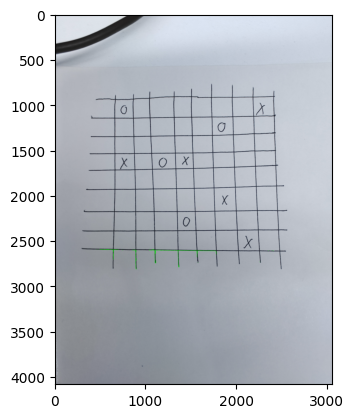

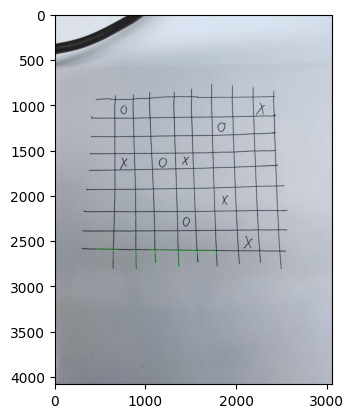

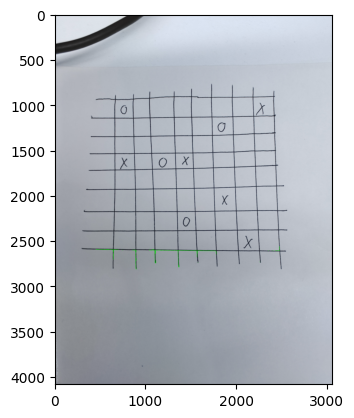

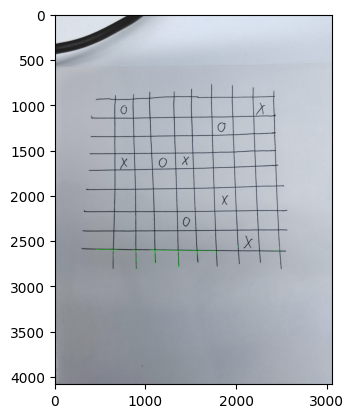

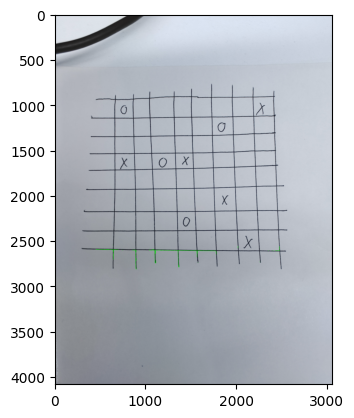

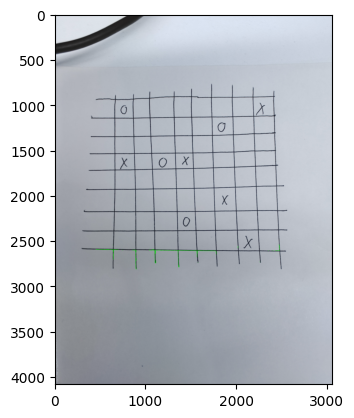

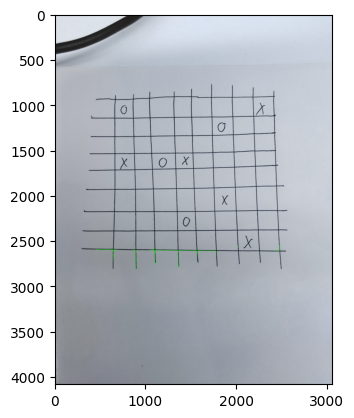

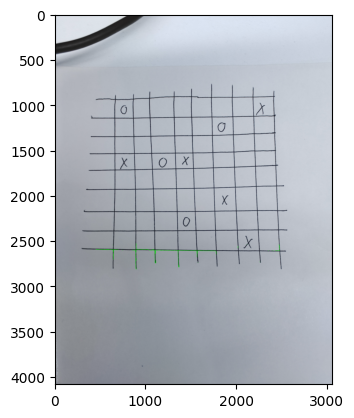

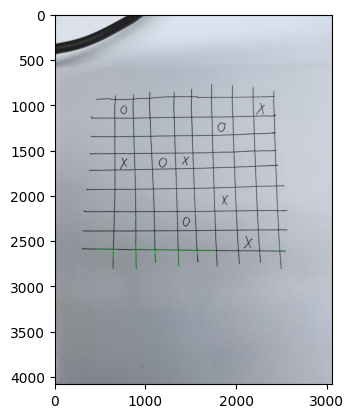

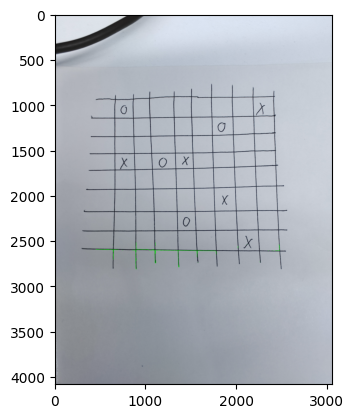

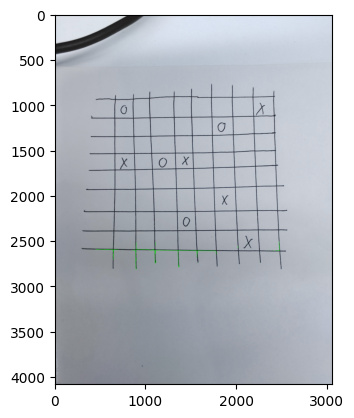

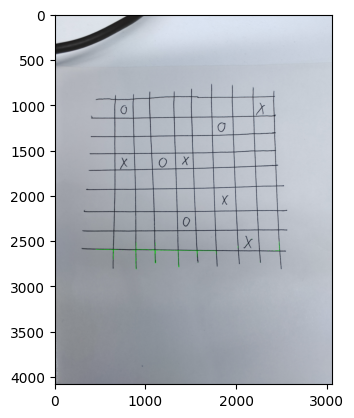

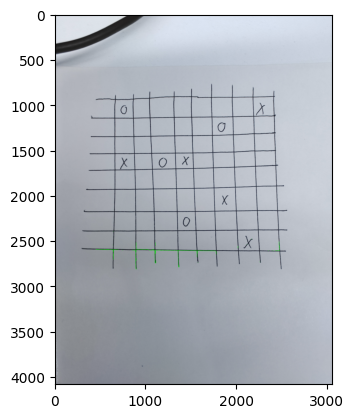

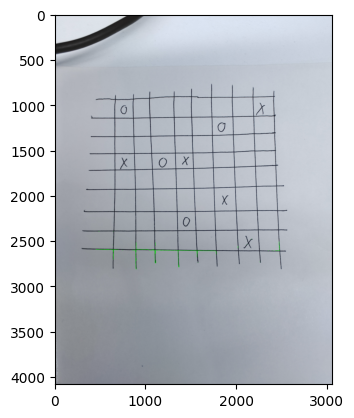

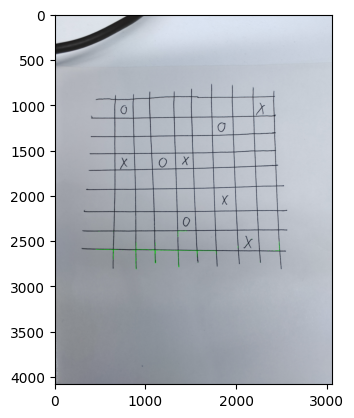

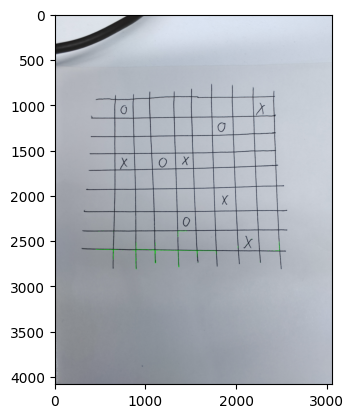

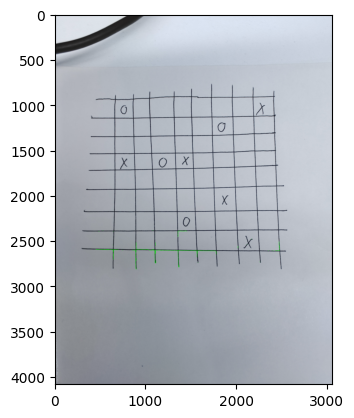

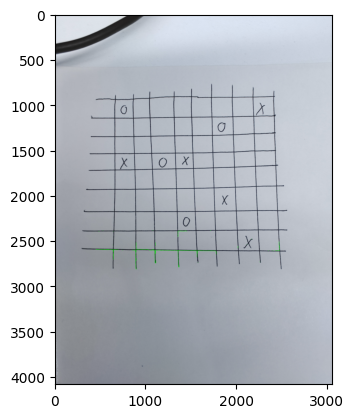

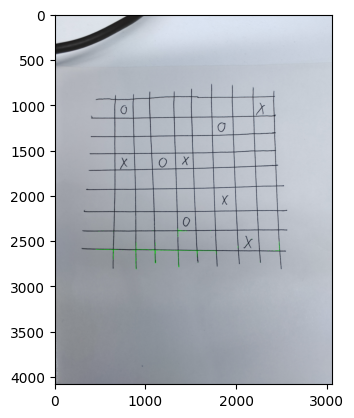

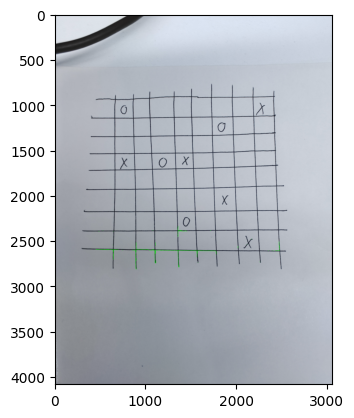

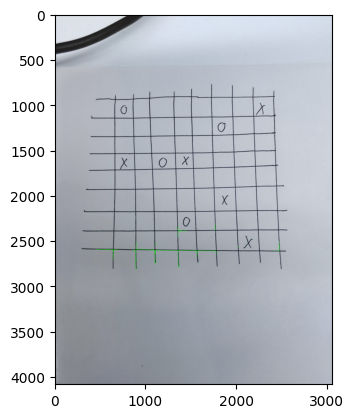

KeyboardInterrupt: 

In [ ]:

# show the original image and the contour image and show the different contours
